# Satellite images of dust (split-window difference)

*Running with flc_local on home laptop*

**Libraries needed:**

In [1]:
#---Cloud search libraries
import s3fs #---The installation of this package on conda makes me nervous for the environment stability
import requests
import fnmatch

#---Accessory libraries
import datetime
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as feature

**Set the datetime to view:**

In [2]:
year = 2024
month = 1
day = 8
hour = 14

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

datetime_str = str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2)+' '+str(hour).zfill(2)+'Z'
print(datetime_str)

008
2024-01-08 14Z


**Select region for visualization:**

In [3]:
#--- US Southwest
latitude_north = 40.5
latitude_south = 27.5
longitude_west = -123
longitude_east = -100

**Connecting to AWS remote storage:**

In [4]:
fs = s3fs.S3FileSystem(anon=True)

**Search the AWS database:**

Split-window difference = 10.3um - 12.3um

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadF' #---Full disk ABI radiance

band_13 = '13' #--- 10.3 um
band_15 = '15' #--- 12.3 um

#---Add band selection here (C**)

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

files_band_15 = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'OR_ABI-L1b-RadF-M6C' + band_15 + '*')]
files_band_13 = [file for file in files if fnmatch.fnmatch(file.split('/')[-1], 'OR_ABI-L1b-RadF-M6C' + band_13 + '*')]

In [6]:
file_15 = files_band_15[0] #---first is the top-of-the-hour
file_13 = files_band_13[0]

print(file_15)

noaa-goes16/ABI-L1b-RadF/2024/008/14/OR_ABI-L1b-RadF-M6C15_G16_s20240081400204_e20240081409518_c20240081409567.nc


In [7]:
resp_15 = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file_15[12:])
if str(resp_15) != '<Response [200]>':
    print('b15 file not found in AWS servers')

resp_13 = requests.get(f'https://'+bucket+'.s3.amazonaws.com/'+file_13[12:])
if str(resp_13) != '<Response [200]>':
    print('b13 file not found in AWS servers')

**Open the satellite data:**

In [8]:
nc_15 = netCDF4.Dataset(file_15, memory = resp_15.content)
ds_15 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_15))

nc_13 = netCDF4.Dataset(file_13, memory = resp_13.content)
ds_13 = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_13))

**Get the latitudes and longitudes for the satellite image:**

In [9]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    #--- Added absolute to remove error
    r_s = (-b - np.sqrt(np.absolute(b**2 - 4*a*c)))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds



def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))

In [10]:
ds_lat_lon_15 = calc_latlon(ds_15)
((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_lat_lon_15, (latitude_south, latitude_north), (longitude_west, longitude_east))
region_15 = ds_lat_lon_15.sel(x=slice(x1, x2), y=slice(y2, y1))

ds_lat_lon_13 = calc_latlon(ds_13)
region_13 = ds_lat_lon_13.sel(x=slice(x1, x2), y=slice(y2, y1))


**Convert radiance to brightness temperature:**

* Satellite data has the conversion constants in the metadata

In [11]:
wl_15 = round(region_15.band_wavelength.values[0],1)
wl_13 = round(region_13.band_wavelength.values[0],1)

Tb_15 = (region_15.planck_fk2/(np.log((region_15.planck_fk1/region_15.Rad)+1)) - region_15.planck_bc1)/region_15.planck_bc2
Tb_13 = (region_13.planck_fk2/(np.log((region_13.planck_fk1/region_13.Rad)+1)) - region_13.planck_bc1)/region_13.planck_bc2

**Create the strings for the save file:**

In [12]:
date_str = str(datetime_str).replace('-', '_').replace(' ', '_')

**Plot the brightness-temperature difference:**

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_31248/2465781859.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


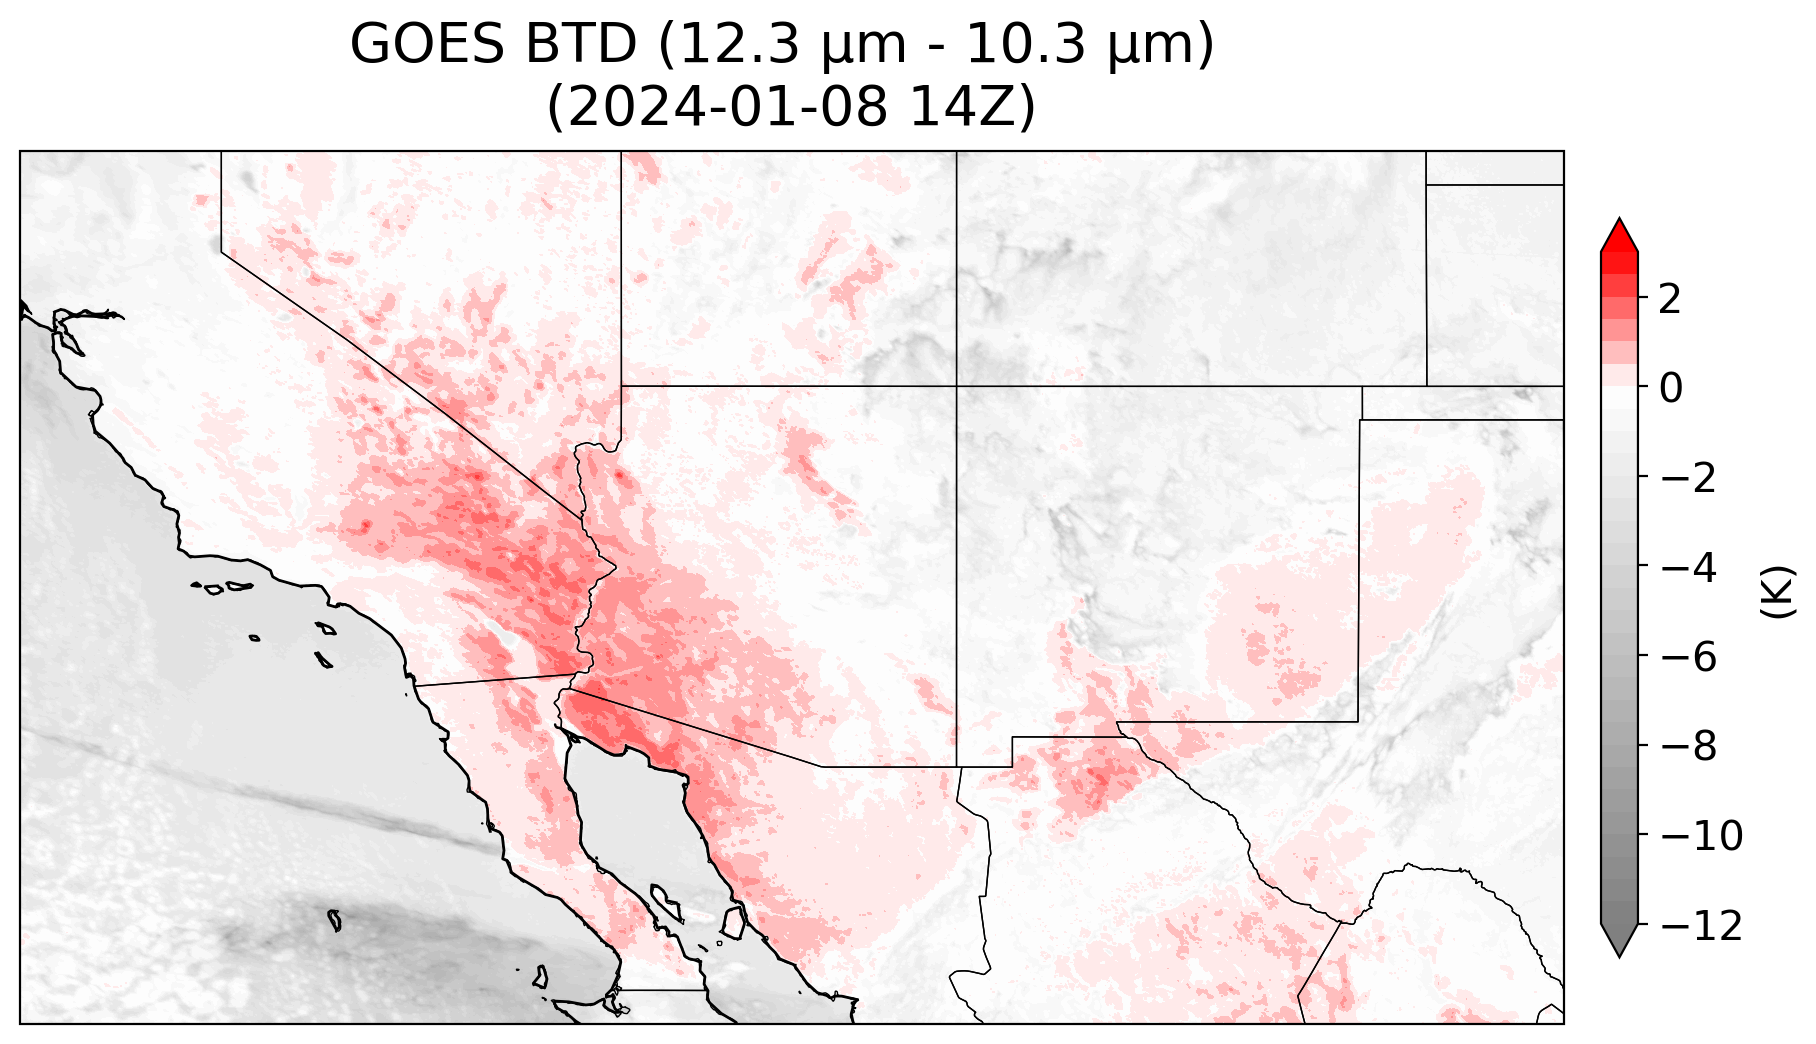

In [13]:

BTD = Tb_15 - Tb_13

projection=ccrs.PlateCarree(central_longitude=0)

fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Define custom colormap: Greys for negative, Reds for positive
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['grey', 'white', 'red'])
# Use TwoSlopeNorm to center at 0
norm = TwoSlopeNorm(vmin=-12, vcenter=0, vmax=3)

levels = np.linspace(-12, 3, 31)

c=ax.contourf(BTD.lon, BTD.lat, BTD, cmap=cmap, extend='both', norm=norm, levels=levels)


clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("GOES BTD ("+ str(wl_15) +" μm - " + str(wl_13) +" μm) \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(feature.STATES, zorder=100, edgecolor='#000', facecolor='none', linewidth=0.5)

fig.set_dpi(200)
fig.savefig("Dust_Identification_Cases/satellite_btd_"+date_str, dpi=200, bbox_inches='tight')
fig.show()